## Leitura do sinal bruto

In [15]:
import sys
print(sys.executable)#Isso mostra o caminho do Python que o notebook está usando.

C:\Users\GABI\OneDrive\Documentos\ECG\venv\Scripts\python.exe


In [3]:
import wfdb
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [17]:
# Sinal físico (em mV)
sinal_bruto = record.p_signal

# Taxa de amostragem
fs = record.fs
print(f"Taxa de amostragem: {fs} Hz")

# Número de amostras
n_amostras = sinal_bruto.shape[0]
print(f"Número de amostras: {n_amostras}")

# Vetor de tempo
amostras = np.arange(n_amostras)


Taxa de amostragem: 360 Hz
Número de amostras: 650000


## Montar o DataFrame bruto e salvar em CSV

Formato do sinal: (650000, 2)
Derivações disponíveis: ['MLII', 'V5']
CSV criado com sucesso!


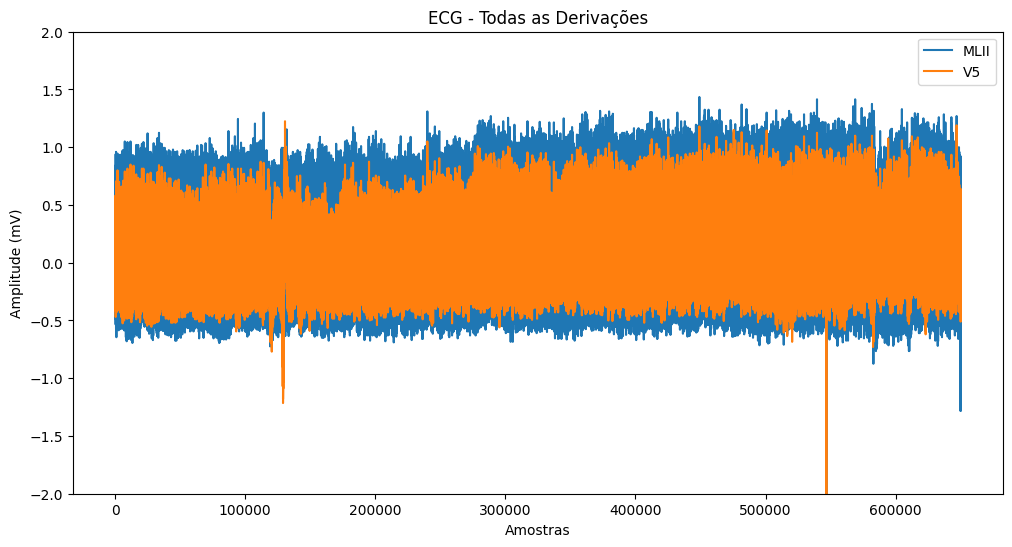

In [23]:
# 1️⃣ Ler o registro (MIT-BIH)
record = wfdb.rdrecord('100', pn_dir='mitdb')  # substitua '100' pelo registro que você quer

# 2️⃣ Pegar o sinal físico (em mV)
sinal = record.p_signal  # sempre use p_signal, não d_signal

# 3️⃣ Verificar dimensões e derivações
print("Formato do sinal:", sinal.shape)      # (n_amostras, n_derivações)
print("Derivações disponíveis:", record.sig_name)

# 4️⃣ Vetor de amostras
n_amostras = sinal.shape[0]
amostras = np.arange(n_amostras)

# Salvar CSV (primeira derivação, exemplo: V5)
df = pd.DataFrame({
    'Tempo_s': np.arange(n_amostras) / fs,
    'V5': sinal[:,0]
})
df.to_csv('ecg_raw.csv', index=False)
print("CSV criado com sucesso!")

# 6️⃣ Plotar todas as derivações
plt.figure(figsize=(12, 6))
for i, nome in enumerate(record.sig_name):
    plt.plot(amostras, sinal[:,i], label=nome)

plt.title('ECG - Todas as Derivações')
plt.xlabel('Amostras')
plt.ylabel('Amplitude (mV)')
plt.ylim(-2, 2)  # ajusta o zoom para visualizar melhor
plt.legend()
plt.show()

## Filtrar a faixa de frequências sem relevância biológica

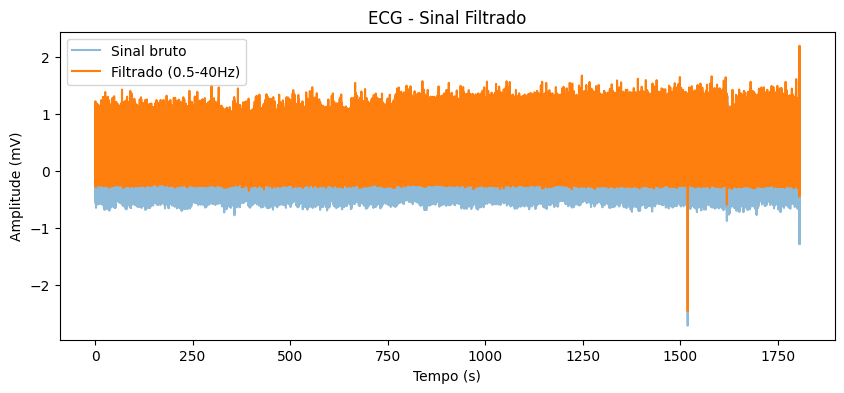

    Tempo_s     V5  ecg_filtrado
0  0.000000 -0.145      0.037467
1  0.002778 -0.145      0.037198
2  0.005556 -0.145      0.037252
3  0.008333 -0.145      0.037958
4  0.011111 -0.145      0.039592


In [25]:
from scipy.signal import butter, sosfiltfilt

# Função para criar filtro passa-banda estável
"""
    Cria um filtro passa-banda Butterworth usando a forma SOS (Second-Order Sections).

    Parâmetros:
        lowcut (float): frequência de corte inferior (Hz)
        highcut (float): frequência de corte superior (Hz)
        fs (int ou float): taxa de amostragem do sinal (Hz)
        order (int): ordem do filtro (define a inclinação da atenuação)

    Retorna:
        sos (ndarray): coeficientes do filtro no formato SOS
    """
def butter_bandpass_sos(lowcut, highcut, fs, order=3):
    
    # Frequência de Nyquist = metade da taxa de amostragem
    # É o limite máximo de frequência representável sem aliasing.
    # Aliasing é um fenômeno que ocorre quando você amostra um sinal analógico a uma taxa muito baixa
    nyquist = 0.5 * fs

    # Normalizar as frequências de corte (torná-las proporcionais à Nyquist)
    low = lowcut / nyquist
    high = highcut / nyquist

    # Criar o filtro Butterworth passa-banda no formato "sos" (Second-Order Sections)
    # O formato SOS melhora a estabilidade numérica, principalmente em filtros de ordem alta.
    sos = butter(order, [low, high], btype='band', output='sos')
    
    return sos

# Configurações do filtro
lowcut = 0.5 # frequência mínima (Hz) — remove variações lentas (como movimento de base)
highcut = 40 # frequência máxima (Hz) — remove ruído muscular e interferência elétrica

# ordem 3 → resposta suave, suficiente para ECGs reais sem instabilidade
sos = butter_bandpass_sos(lowcut, highcut, fs, order=3)

# Aplicar filtro de forma estável
# A função sosfiltfilt aplica o filtro nas duas direções (frente e verso).
# Isso elimina o "atraso de fase" — problema comum em filtros digitais —
# garantindo que o sinal filtrado mantenha o alinhamento temporal com o original.
# O resultado é um sinal mais limpo e fisiologicamente fiel.
df['ecg_filtrado'] = sosfiltfilt(sos, df['V5'])


# Visualizar sinal filtrado
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 4))
plt.plot(df['Tempo_s'], df['V5'], label='Sinal bruto', alpha=0.5)
plt.plot(df['Tempo_s'], df['ecg_filtrado'], label='Filtrado (0.5-40Hz)')
plt.legend()
plt.xlabel('Tempo (s)')
plt.ylabel('Amplitude (mV)')
plt.title('ECG - Sinal Filtrado')
plt.show()

## Zoom / Seção ampliada

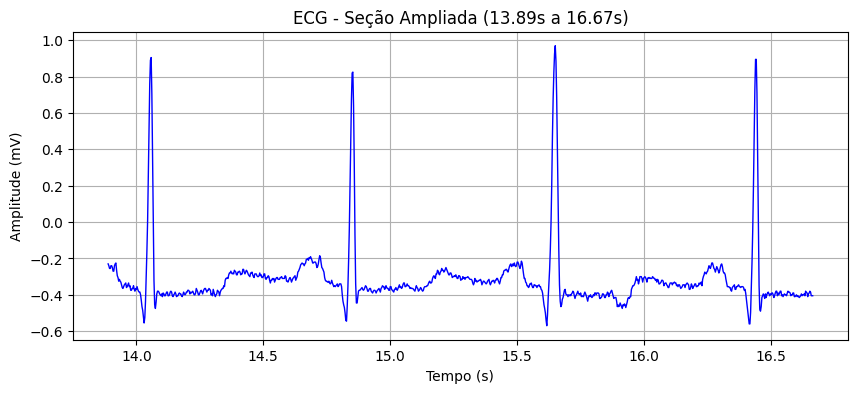

In [27]:
# Escolher a faixa de amostras para ampliar
# Cada 360 amostras ≈ 1 segundo (pois fs = 360 Hz)
start_index = 5000   # início da seção (pode ajustar)
end_index = 6000     # fim da seção

# Selecionar apenas essa parte do sinal
zoomed_data = df.iloc[start_index:end_index]

# --- Plotar a seção ampliada ---
plt.figure(figsize=(10, 4))
plt.plot(zoomed_data['Tempo_s'], zoomed_data['V5'], color='blue', linewidth=1)

# Adicionar título dinâmico com o intervalo em segundos
plt.title(f"ECG - Seção Ampliada ({df['Tempo_s'].iloc[start_index]:.2f}s a {df['Tempo_s'].iloc[end_index]:.2f}s)")

plt.xlabel("Tempo (s)")
plt.ylabel("Amplitude (mV)")
plt.grid(True)
plt.show()


## Detectar picos QRS (R)

In [28]:
from scipy.signal import find_peaks

# Definir taxa de amostragem
fs = 360

# Distância mínima entre picos R (~0.6s entre batimentos)
distancia_minima = int(0.6 * fs)

# Encontrar a amplitude máxima do sinal filtrado
# np.abs() garante que detectaremos picos mesmo se o sinal estiver invertido
amp_max = np.max(np.abs(df['ecg_filtrado'].values))

# Definir altura mínima dos picos (10% da amplitude máxima)
altura = amp_max * 0.1

# Detectar picos R
# O sinal do MIT-BIH costuma ter os picos R negativos, por isso usamos o sinal invertido (-)
picos_R, propriedades = find_peaks(
    -df['ecg_filtrado'].values,   # inverte o sinal
    height=altura,                # altura mínima
    distance=distancia_minima,    # distância mínima entre picos
    prominence=altura             # destaque mínimo dos picos
)

print(f"Picos R encontrados: {len(picos_R)}")

Picos R encontrados: 908


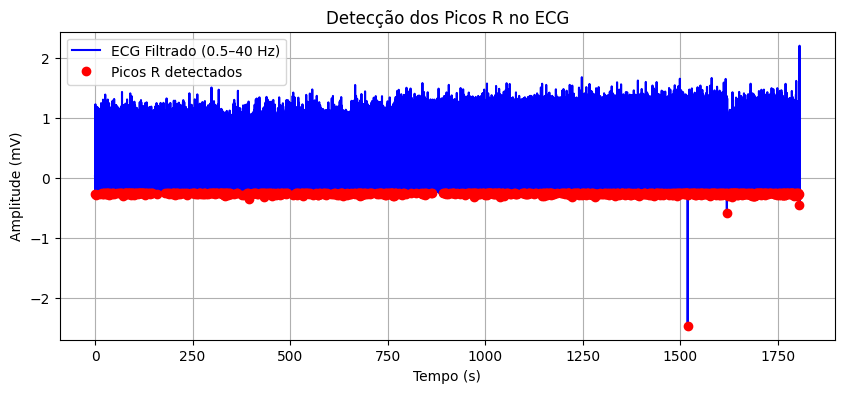

In [29]:
# Adicionar tempos correspondentes
tempos_R = df['Tempo_s'].iloc[picos_R].values

# Plotar resultados
plt.figure(figsize=(10, 4))
plt.plot(df['Tempo_s'], df['ecg_filtrado'], label='ECG Filtrado (0.5–40 Hz)', color='blue')
plt.plot(tempos_R, df['ecg_filtrado'].iloc[picos_R], 'ro', label='Picos R detectados')
plt.xlabel('Tempo (s)')
plt.ylabel('Amplitude (mV)')
plt.title('Detecção dos Picos R no ECG')
plt.legend()
plt.grid(True)
plt.show()

### Zoom para visualizar picos R detectados

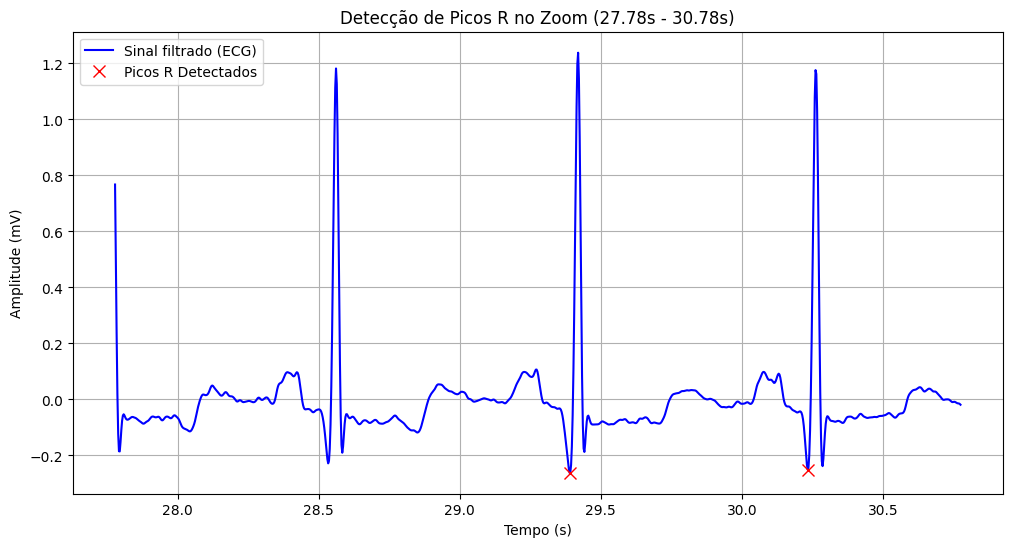

In [30]:
# Zoom para visualizar picos R detectados 
# Definir índices de início e fim do zoom (ajuste conforme desejar)
zoom_start_index = 10000  # índice inicial da seção
zoom_end_index = zoom_start_index + int(3 * fs)  # 3 segundos de sinal

# Selecionar apenas os dados da seção ampliada
zoomed_data = df.iloc[zoom_start_index:zoom_end_index]

# Selecionar apenas os picos R que estão dentro do intervalo do zoom
picos_in_zoom = picos_R[(picos_R >= zoom_start_index) & (picos_R < zoom_end_index)]

# Criar gráfico
plt.figure(figsize=(12, 6))

# Plotar o sinal filtrado no trecho selecionado
plt.plot(zoomed_data['Tempo_s'], zoomed_data['ecg_filtrado'],
         label='Sinal filtrado (ECG)', color='blue')

# Marcar os picos R detectados nesse trecho
plt.plot(df['Tempo_s'].iloc[picos_in_zoom], df['ecg_filtrado'].iloc[picos_in_zoom],
         "x", label='Picos R Detectados', color='red', markersize=8)

# Configurações do gráfico
plt.title(f'Detecção de Picos R no Zoom ({df["Tempo_s"].iloc[zoom_start_index]:.2f}s - {df["Tempo_s"].iloc[zoom_end_index]:.2f}s)')
plt.xlabel('Tempo (s)')
plt.ylabel('Amplitude (mV)')
plt.legend()
plt.grid(True)
plt.show()


### Estimar a frequência cardíaca

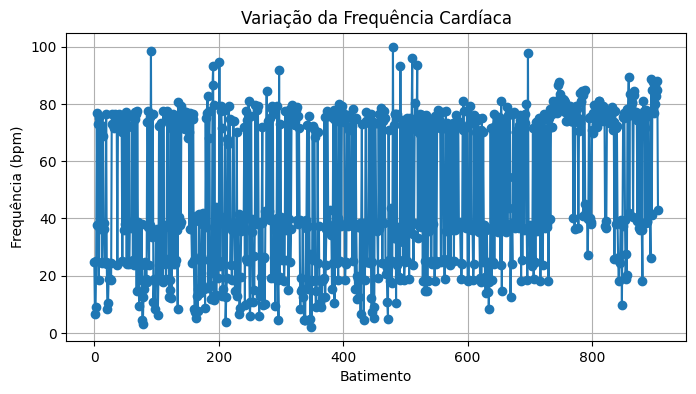

In [31]:
# Calcular intervalos RR (em segundos)
# Cada pico R representa um batimento cardíaco detectado no ECG.
# A função np.diff calcula a diferença entre tempos consecutivos
# (tempo do batimento atual - tempo do batimento anterior).
# 'RR_intervals' contém os intervalos de tempo entre batimentos — em segundos.
RR_intervals = np.diff(df['Tempo_s'].iloc[picos_R])

# Converter para frequência cardíaca (batimentos por minuto)
frequencia_cardiaca = 60 / RR_intervals

# Plotar a variação dos batimentos
plt.figure(figsize=(8,4))
plt.plot(frequencia_cardiaca, marker='o') # gráfico com marcadores circulares
plt.title("Variação da Frequência Cardíaca")
plt.xlabel("Batimento")
plt.ylabel("Frequência (bpm)")
plt.grid(True)
plt.show()


## Detectar ondas P e T

In [32]:
# Criar listas para armazenar os índices das ondas P e T
picos_P = []
picos_T = []

# Janela relativa ao pico R (em amostras)
janela_P = int(0.2 * fs)  # 200 ms antes do R
janela_T = int(0.4 * fs)  # 400 ms após o R

for r in picos_R:
    # Onda P: buscar pico máximo antes do R
    inicio_P = max(r - janela_P, 0)#max(..., 0) garante que não seja negativo.
    fim_P = r
    
    #argmax() → retorna o índice do valor máximo dentro da janela, ou seja, o pico da onda P.
    #inicio_P + ... → converte o índice relativo da janela para o índice global no DataFrame.
    P_peak = inicio_P + df['ecg_filtrado'].values[inicio_P:fim_P].argmax()
    
    #picos_P.append(P_peak) → adiciona o índice da onda P à lista.
    picos_P.append(P_peak)
    
    # Onda T: buscar pico máximo após o R
    inicio_T = r
    #fim da janela 400 ms depois do R, sem ultrapassar o tamanho do sinal
    fim_T = min(r + janela_T, len(df['ecg_filtrado']))
    T_peak = inicio_T + df['ecg_filtrado'].values[inicio_T:fim_T].argmax()
    picos_T.append(T_peak)#T_peak adicionado à lista picos_T

print(f"Detectadas {len(picos_P)} ondas P e {len(picos_T)} ondas T")


Detectadas 908 ondas P e 908 ondas T


### Visualizar todos os picos

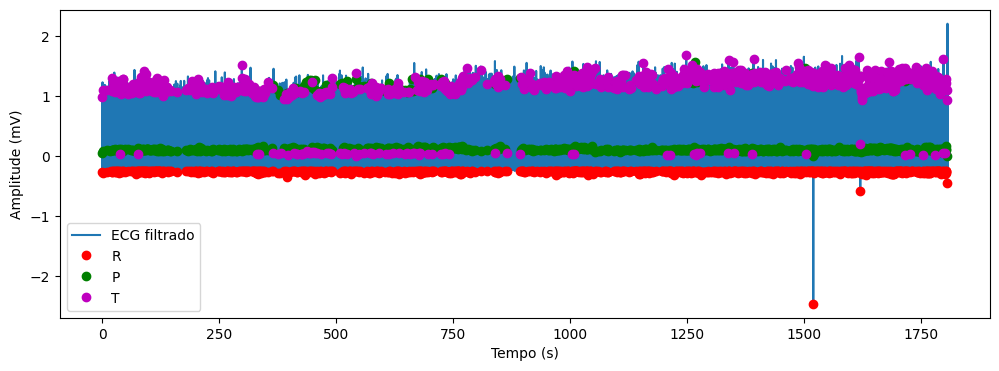

In [33]:
plt.figure(figsize=(12,4))
plt.plot(df['Tempo_s'], df['ecg_filtrado'], label='ECG filtrado')

#Marcar os picos R no gráfico
# df['Tempo_s'].iloc[picos_R] → obtém o tempo de cada pico R
# df['ecg_filtrado'].iloc[picos_R] → obtém a amplitude correspondente a cada pico R
# 'ro' → marcador circular (o) na cor vermelha (r)
# label='R' → legenda indicando que esses pontos são picos R
plt.plot(df['Tempo_s'].iloc[picos_R], df['ecg_filtrado'].iloc[picos_R], 'ro', label='R')

# Marcar as ondas P
plt.plot(df['Tempo_s'].iloc[picos_P], df['ecg_filtrado'].iloc[picos_P], 'go', label='P')

# Marcar as ondas T
# 'mo' → marcador circular magenta (m)
# Essas marcas ajudam a visualizar se as ondas T estão sendo detectadas corretamente
plt.plot(df['Tempo_s'].iloc[picos_T], df['ecg_filtrado'].iloc[picos_T], 'mo', label='T')

plt.xlabel('Tempo (s)')
plt.ylabel('Amplitude (mV)')
plt.legend()
plt.show()


## Amplitudes e larguras dos picos

In [20]:
from scipy.signal import peak_widths 
#peak_widths função específica para medir a largura de picos detectados com find_peaks

# Calcular amplitudes e larguras dos picos R
# peak_widths retorna a largura em número de amostras e os pontos onde a largura é medida
largura_R, altura_R, left_ips_R, right_ips_R = peak_widths(-df['ecg_filtrado'].values, picos_R, rel_height=0.5)

# Converter largura de amostras para segundos
largura_R_seg = largura_R / fs

# Calcular amplitude (em mV) dos picos R
amplitude_R = df['ecg_filtrado'].values[picos_R]

print(f"Média da amplitude dos picos R: {np.mean(amplitude_R):.3f} mV")
print(f"Média da largura dos picos R: {np.mean(largura_R_seg)*1000:.1f} ms")

# Repetir o processo para ondas P
largura_P, altura_P, left_ips_P, right_ips_P = peak_widths(df['ecg_filtrado'].values, picos_P, rel_height=0.5)
largura_P_seg = largura_P / fs
amplitude_P = df['ecg_filtrado'].values[picos_P]

print(f"Média da amplitude das ondas P: {np.mean(amplitude_P):.3f} mV")
print(f"Média da largura das ondas P: {np.mean(largura_P_seg)*1000:.1f} ms")

# Repetir o processo para ondas T
largura_T, altura_T, left_ips_T, right_ips_T = peak_widths(df['ecg_filtrado'].values, picos_T, rel_height=0.5)
largura_T_seg = largura_T / fs
amplitude_T = df['ecg_filtrado'].values[picos_T]

print(f"Média da amplitude das ondas T: {np.mean(amplitude_T):.3f} mV")
print(f"Média da largura das ondas T: {np.mean(largura_T_seg)*1000:.1f} ms")


Média da amplitude dos picos R: -0.003 mV
Média da largura dos picos R: 755.3 ms
Média da amplitude das ondas P: 0.002 mV
Média da largura das ondas P: 338.0 ms
Média da amplitude das ondas T: 0.011 mV
Média da largura das ondas T: 29.3 ms
